# Comparing Permutation and Bootstrap

In this notebook we compare the permutation and bootstrap JER control methods in the two sample case.

In [1]:
import numpy as np
import numpy.matlib as npm
import sys
import matplotlib.pyplot as plt 

import sanssouci as sa

import pyrft as pr
import random

### Initialize the example (using the equi-corr example here)

In [72]:
random.seed(a=2021)

m = 2000         # number of variables     (eg : number of voxels in an image)
n = 80            # number of observations  (eg : number of images)
pi0 = 0.99        # proportion of noise (true null hypotheses)
p0 = int(np.round(pi0*m)) # number of true null hypotheses (non active voxels)
rho = 0.3        # equi-correlation
s = 1          # signal to noise ratio (because sigma is 1 CHECK!)

# generate noise
Z=np.random.randn(n,m)
w=np.random.randn(n)
W=Z.copy()
for i in range(m):
  W[:,i]=w[:] # W has the same w for each subject to ensure the dependence
Y=np.sqrt(1-rho)*Z + np.sqrt(rho)*W

# cov(Y_n(v), Y_m(v)) = E( sqrt(1-rho)z_n + sqrt(rho)*w,sqrt(1-rho)z_m + sqrt(rho)*w) = (1-rho)delta_{nm} + rho
# (as var(w) = 1 = var(z_n) = var(z_m)) (so the text above is wrong!)

# add signal (for false null hypotheses)
categ=np.random.binomial(1, 0.5, size=n) # Equal probability of each - but ususally not balanced in fact!
data = Y.copy()
w1=np.where(categ==1)
# Add signal to the data when the category is 1! :)
data[w1, (p0+1):m] = Y[w1, (p0+1):m] + s

# Record where the signal is as a boolean vector
bool_signal = np.ones((m,1)) == 0
bool_signal[(p0+1):m] = True
sum(bool_signal)

array([19])

### JER control using permutation

In [73]:
# Initialize the number of bootstraps and the alpha level
B = 100; alpha = 0.1;
pval0 = sa.get_perm_p(data, categ, B=B , row_test_fun=sa.row_welch_tests)
piv_stat = sa.get_pivotal_stats(pval0, K=m)
lambda_perm = np.quantile(piv_stat, alpha)

print('Lambda Perm:', lambda_perm)
thr_perm = sa.t_linear(lambda_perm, np.arange(1,m+1), m)

Lambda Perm: 0.16809417832082119


### JER control using bootstrap

In [74]:
# Generate the design matrix from the category vector
X = pr.groupX(categ); 

# Set the contrast matrix
C = np.array([1,-1]); 

# Run the bootstrap JER algorithm
minPperm, orig_pvalues, pivotal_stats, bs = pr.boot_contrasts(data.transpose(), X, C, B)

# Obtain the lambda calibration
lambda_boot = np.quantile(pivotal_stats, alpha)
print('Lambda Boot:', lambda_boot)

thr_boot = sa.t_linear(lambda_boot, np.arange(1,m+1), m)

Lambda Boot: 0.22169817104882306


Calculate the p-values (note that the bootstrap and permutation methods as coded use different two sample test so the p-values are slightly different)

In [75]:
rwt = sa.row_welch_tests(data, categ)
pvals_perm = rwt['p_value']
print(pvals_perm.shape)
pval_sort_idx_perm = np.argsort(pvals_perm)

pval_sort_idx_boot = np.argsort(np.ravel(orig_pvalues.field))
pvals_boot = np.ravel(orig_pvalues.field)[pval_sort_idx_boot]

(2000,)


### Compare permutation and bootstrap p-values

The p values are very close between the two methods (with use different 2 sample tests) but are slightly different, especially in the tails

[0.91441169 0.63719979 0.67421092 0.16395332 0.4586764  0.35475355
 0.94799049 0.93035371 0.3676987  0.9034944 ]
[6.87016710e-08 2.52173899e-07 3.44377069e-07 5.07193916e-07
 5.72052397e-07 1.31105815e-06 6.99083336e-06 7.88666133e-06
 1.41912472e-05 3.49604309e-05]
[0.96987519 0.54907802 0.48404659 0.64763504 0.41243017 0.79204907
 0.61732286 0.13799511 0.84770543 0.49187947]
[0.57859986 0.57895101 0.57905409 0.57924137 0.5805153  0.58062024
 0.58094863 0.58125276 0.5813695  0.58151185]


Text(0.5, 1.0, 'Comparing the p-values from the two methods')

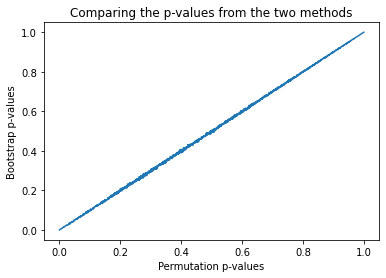

In [76]:
print(pvals_perm[0:10])
print(pvals_boot[0:10])
print(pvals_perm[1000:1010])
print(pvals_boot[1000:1010])

plt.plot(pvals_perm[pval_sort_idx_boot], pvals_boot)
plt.xlabel('Permutation p-values')
plt.ylabel('Bootstrap p-values')
plt.title('Comparing the p-values from the two methods')

### Generate a histogram of the p-values

Note that for low numbers of voxels this is not uniform because the data is highly correlated

(array([122., 135., 184., 205., 168., 236., 234., 235., 241., 240.]),
 array([1.09092244e-07, 9.99659642e-02, 1.99931819e-01, 2.99897674e-01,
        3.99863530e-01, 4.99829385e-01, 5.99795240e-01, 6.99761095e-01,
        7.99726950e-01, 8.99692805e-01, 9.99658660e-01]),
 <a list of 10 Patch objects>)

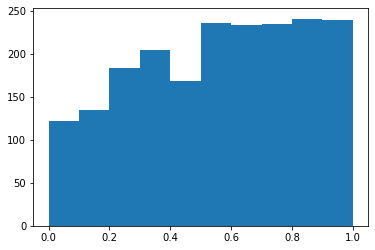

In [77]:
plt.hist(pvals_perm)

### Plot the FPR and TP curve bounds

The input p-values were not sorted -> this is done now


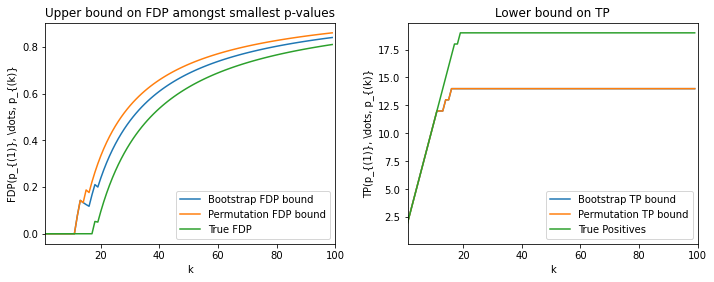

In [81]:
max_FP_perm = sa.curve_max_fp(pvals_perm, thr_perm)
max_FP_boot = sa.curve_max_fp(pvals_boot, thr_boot)

# Generate the vector [0,...,m]
one2npvals = np.arange(1, m+1)

# Choose the number of p-values (always the smallest ones first) to plot
lowestnumber = 100

# Ensure that selected number is not greater than the total number of p-values
lowestnumber = np.min([lowestnumber,m])

# Dividing the envelope by the number of elements in the set gives a bound on the false discovery proportion
max_FDP_boot = max_FP_boot[0:lowestnumber]/ one2npvals[0:lowestnumber] 
min_TP_boot = one2npvals[0:lowestnumber] - max_FP_boot[0:lowestnumber]
max_FDP_perm = max_FP_perm[0:lowestnumber]/ one2npvals[0:lowestnumber] 
min_TP_perm = one2npvals[0:lowestnumber] - max_FP_perm[0:lowestnumber]

# Calculate the truth (to determine if it is correctly bounded!)
sorted_signal = bool_signal[pval_sort_idx_boot]
TP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    TP[I] = np.sum(sorted_signal[0:I+1])
    
# Calculate the true FDP for each subset
FP = np.zeros(lowestnumber)
for I in np.arange(lowestnumber):
    FP[I] = np.sum(abs(sorted_signal[0:I+1]-1))
true_FDP = FP/one2npvals[0:lowestnumber] 
    
# Initialize the figure
figure = plt.figure(figsize=(10,4))

# Plot the false discovery proportion and its bound
plt.subplot(121)
plt.plot(max_FDP_boot, label = 'Bootstrap FDP bound')
plt.plot(max_FDP_perm, label = 'Permutation FDP bound')
plt.plot(true_FDP, label = 'True FDP')
plt.title('Upper bound on FDP amongst smallest p-values')
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('FDP(p_{(1)}, \dots, p_{(k)}')
plt.legend(loc="lower right")

# Plot the true postives and their bound
plt.subplot(122)
plt.plot(min_TP_perm, label = 'Bootstrap TP bound')
plt.plot(min_TP_perm, label = 'Permutation TP bound')
plt.plot(TP, label = 'True Positives')
plt.title('Lower bound on TP')
plt.legend(loc="lower right")
plt.xlim(1, lowestnumber)
plt.xlabel('k')
plt.ylabel('TP(p_{(1)}, \dots, p_{(k)}')
#figure, axes = plt.subplots(nrows=1, ncols=2) 
figure.tight_layout(pad=1.0)

### Analyzing the impact of lambda changes on the FDP curve

Suprisingly the value of lambda doesn't appear to make much of a difference!

Lambda Perm: 0.19194044467221172
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now


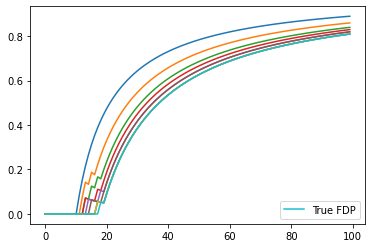

In [80]:
# Initialize the number of bootstraps and the alpha level
B = 100; alpha = 0.1;
pval0 = sa.get_perm_p(data, categ, B=B , row_test_fun=sa.row_welch_tests)
piv_stat = sa.get_pivotal_stats(pval0, K=m)
lambda_perm = np.quantile(piv_stat, alpha)

print('Lambda Perm:', lambda_perm)
thr_perm = sa.t_linear(lambda_perm, np.arange(1,m+1), m)

n2use = 100;
lambda_set = np.arange(10)/10
print(lambda_set)
lambda_set = lambda_set[1:]
for I in np.arange(len(lambda_set)):
    thresh = sa.t_linear(lambda_set[I], np.arange(1,m+1), m)
    max_FP_perm = sa.curve_max_fp(pvals_perm, thresh)
    max_FDP_perm = max_FP_perm[0:n2use]/one2npvals[0:n2use] 
    plt.plot(max_FDP_perm)
plt.plot(true_FDP[0:n2use], label = 'True FDP')
plt.legend(loc="lower right")

[0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now


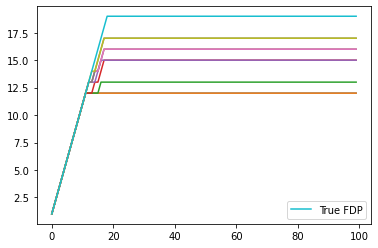

In [63]:
lambda_set = np.arange(10)/10
lambda_set = lambda_set[1:]
print(lambda_set)
n2use = 100
for I in np.arange(len(lambda_set)):
    thresh = sa.t_linear(lambda_set[I], np.arange(1,m+1), m)
    max_FP_perm = sa.curve_max_fp(pvals_perm, thresh)
    min_TP_perm = np.arange(1,m+1) - max_FP_perm
    plt.plot(min_TP_perm[0:n2use])
plt.plot(TP[0:n2use], label = 'True FDP')
plt.legend(loc="lower right")

Analyzing for very low lambda

The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now
The input p-values were not sorted -> this is done now


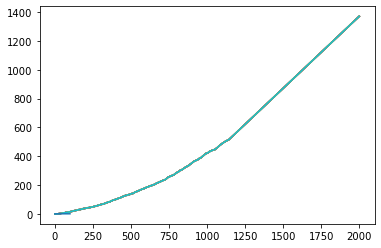

In [11]:
lambda_set = np.arange(10)/10000
for I in np.arange(len(lambda_set)):
    thresh = sa.t_linear(lambda_set[I], np.arange(1,m+1), m)
    max_FP_perm = sa.curve_max_fp(pvals_perm, thresh)
    plt.plot(max_FDP_perm)
plt.plot(true_FDP, label = 'True FDP')